# Instacart: Predicting Product Reorder

# Research Question:
+ **Will a user re-order a product via the Instacart app and what can we learn about improving those chances?**

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_aisles = pd.read_csv('datasets/unit 3 capstone/instacart/aisles.csv')
df_departments = pd.read_csv('datasets/unit 3 capstone/instacart/departments.csv')
df_order_products_prior = pd.read_csv('datasets/unit 3 capstone/instacart/order_products_prior.csv')
df_order_products_train = pd.read_csv('datasets/unit 3 capstone/instacart/order_products_train.csv')
df_orders = pd.read_csv('datasets/unit 3 capstone/instacart/orders.csv')
df_products = pd.read_csv('datasets/unit 3 capstone/instacart/products.csv')
df_sample_submission = pd.read_csv('datasets/unit 3 capstone/instacart/sample_submission.csv')

In [3]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
df_order_products_prior.tail()

,order_id,product_id,add_to_cart_order,reordered
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [6]:
df_order_products_train.tail()

,order_id,product_id,add_to_cart_order,reordered
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [7]:
df_orders.sort_values(by=['order_id']).tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0
419472,3421083,25247,prior,24,2,6,21.0


In [8]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
df_order_products_train.shape

(1384617, 4)

In [10]:
print(df_aisles.isnull().sum())
print(df_departments.isnull().sum())
print(df_order_products_prior.isnull().sum())
print(df_order_products_train.isnull().sum())
print(df_orders.isnull().sum())
print(df_products.isnull().sum())
print(df_sample_submission.isnull().sum())

aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
order_id    0
products    0
dtype: int64


### Engineering Feature Set

+ **Creating feature set from merged product data**
- **Selecting randomized data subset for computational workload reduction**

In [11]:
features = pd.merge(df_order_products_train, df_orders, on='order_id')
features = pd.merge(features, df_products, on='product_id')
features = features.drop(['eval_set'], axis=1)
features = features.sample(n=50000)

features.tail()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
1321357,3217648,44870,3,0,80622,9,5,12,13.0,Franks,106,12
931421,1947588,15700,9,0,121696,10,4,12,2.0,Cheddar Cheese Nut Thins Cracker Snacks,78,19
1363545,1100380,6455,1,0,32855,6,5,9,30.0,Organic Magic Muesli,68,10
665536,805516,40377,8,1,106547,7,2,12,5.0,Unrefined Virgin Coconut Oil,19,13
593831,1984010,43464,3,1,47065,11,4,17,30.0,Unscented Liquid Laundry Detergent,75,17


In [12]:
# Setting 'days_since_prior_order' null values to 0

features['days_since_prior_order'] = features['days_since_prior_order'].fillna(0)

+ **Variable distributions**

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


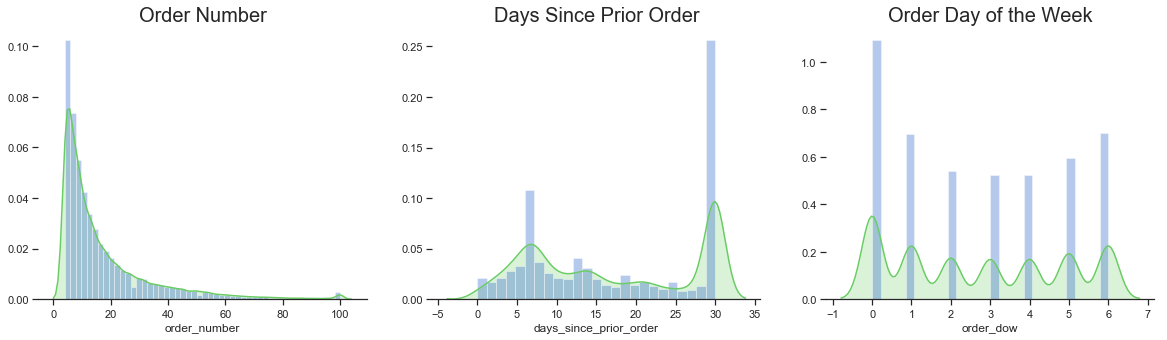

In [13]:
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context(rc={'axes.titlesize':20,'axes.labelsize':12})
sns.set_style('ticks', {'xtick.major.size': 0.2})

fig = plt.figure(figsize=(20,5))

fig.add_subplot(131)
sns.distplot(features['order_number'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Order Number')

fig.add_subplot(132)
sns.distplot(features['days_since_prior_order'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Days Since Prior Order')

fig.add_subplot(133)
sns.distplot(features['order_dow'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Order Day of the Week')

sns.despine(left=True)

**Creating dummies:**
+ **Higher order numbers may be more reliable and predictable (1 - 5)**
- **A more common day since a prior order suggests routine**
- **The most common shopping day of the week suggests routine**

In [14]:
features['days_since_prior_order_most_common'] = 0
features['order_dow_most_common'] = 0

features.loc[(features['days_since_prior_order'] == 6), 'days_since_prior_order_most_common'] = 1
features.loc[(features['order_dow'] == 0), 'order_dow_most_common'] = 1

features['order_number_rank'] = 0

features.loc[(features['order_number'] >= 0), 'order_number_rank'] = 1
features.loc[(features['order_number'] >= 20), 'order_number_rank'] = 2
features.loc[(features['order_number'] >= 40), 'order_number_rank'] = 3
features.loc[(features['order_number'] >= 60), 'order_number_rank'] = 4
features.loc[(features['order_number'] >= 80), 'order_number_rank'] = 5

In [15]:
features.tail()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,days_since_prior_order_most_common,order_dow_most_common,order_number_rank
1321357,3217648,44870,3,0,80622,9,5,12,13.0,Franks,106,12,0,0,1
931421,1947588,15700,9,0,121696,10,4,12,2.0,Cheddar Cheese Nut Thins Cracker Snacks,78,19,0,0,1
1363545,1100380,6455,1,0,32855,6,5,9,30.0,Organic Magic Muesli,68,10,0,0,1
665536,805516,40377,8,1,106547,7,2,12,5.0,Unrefined Virgin Coconut Oil,19,13,0,0,1
593831,1984010,43464,3,1,47065,11,4,17,30.0,Unscented Liquid Laundry Detergent,75,17,0,0,1


# Looking at target class balance

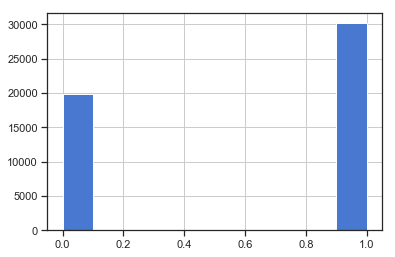

In [16]:
features['reordered'].hist()

# Explanitory Power: Where can we intervene?
+ **Association (Market-Basket) Analysis**
- **What product orders are associated and is that related to reorder?**

In [17]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [18]:
basket = (features[features.index >= 10000]
          .groupby(['order_id', 'product_id'])['add_to_cart_order']
          .sum().unstack().reset_index().fillna(0)
          .set_index('order_id'))

In [19]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [20]:
frequent_itemsets = apriori(basket_sets, min_support=0.0005, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.000597,(45)
1,0.001635,(196)
2,0.001427,(260)
3,0.001064,(432)
4,0.000623,(651)


+ **Converting column frozenset to string**

In [21]:
product_id = []

for i in range(len(frequent_itemsets['itemsets'])):
    for j in frequent_itemsets['itemsets'][i]:
        product_id.append(j)
    
frequent_itemsets['product_id'] = product_id
frequent_itemsets = frequent_itemsets.drop(['itemsets'], axis=1)

In [22]:
frequent_itemsets = pd.merge(frequent_itemsets, df_products, on='product_id', how='outer')
frequent_itemsets = frequent_itemsets.drop(['aisle_id', 'department_id'], axis=1)
frequent_itemsets.sort_values('support', axis=0, ascending=False).head(15)

,support,product_id,product_name
156,0.018733,24852,Banana
124,0.010819,21137,Organic Strawberries
135,0.009963,21903,Organic Baby Spinach
69,0.008225,13176,Bag of Organic Bananas
330,0.008043,47766,Organic Avocado
326,0.007654,47626,Large Lemon
325,0.007291,47209,Organic Hass Avocado
93,0.005864,16797,Strawberries
166,0.005475,26209,Limes
182,0.005371,27966,Organic Raspberries


+ **Tying support values to products**
- **Outer merge to give products support values and replacing any NaN with 0**

In [23]:
frequent_itemsets = frequent_itemsets.drop(['product_name'], axis=1)
features = pd.merge(frequent_itemsets, features, on='product_id', how='outer')
features['support'] = features['support'].fillna(0)
features = features.dropna()

+ **Creating a feature associating the following:**<p/>
    - **Banana(s) & Strawberries**
    - **Large Lemon, Limes & Organic Hass Avocado**
    - **Raspberries & Blueberries**
    - **Organic Zucchini & Asparagus**

In [24]:
# Banana(s) & Strawberries

features['bananas_strawberries'] = 0
features.loc[(features['product_name'].str.contains("banana", case=False), 'bananas_strawberries')] = 1
features.loc[(features['product_name'].str.contains("bananas", case=False), 'bananas_strawberries')] = 1
features.loc[(features['product_name'].str.contains("strawberries", case=False), 'bananas_strawberries')] = 1

# Lemon, Limes & Avocados

features['lemon_lime_avocado'] = 0
features.loc[(features['product_name'].str.contains("large lemon", case=False), 'lemon_lime_avocado')] = 1
features.loc[(features['product_name'].str.contains("limes", case=False), 'lemon_lime_avocado')] = 1
features.loc[(features['product_name'].str.contains("organic hass avocado", case=False), 'lemon_lime_avocado')] = 1

# Raspberries & Blueberries

features['raspberries_blueberries'] = 0
features.loc[(features['product_name'].str.contains("raspberries", case=False), 'raspberries_blueberries')] = 1
features.loc[(features['product_name'].str.contains("blueberries", case=False), 'raspberries_blueberries')] = 1

# Zucchini & Asparagus

features['zucchini_asparagus'] = 0
features.loc[(features['product_name'].str.contains("organic zucchini", case=False), 'zucchini_asparagus')] = 1
features.loc[(features['product_name'].str.contains("asparagus", case=False), 'zucchini_asparagus')] = 1

+ **Let's make a dummy for organic products while we're at it...**

In [25]:
features['organic'] = 0
features.loc[(features['product_name'].str.contains("organic", case=False), 'organic')] = 1

+ **Checking for muliticollinearity**

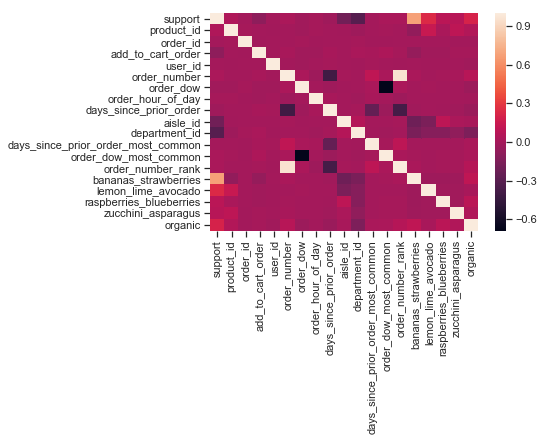

In [26]:
X = features.drop(['reordered'], axis=1)

sns.heatmap(X.corr())

+ **Feature selection with SelectKBest**
- **Removing string variables and id variables to avoid data leakage**

In [27]:
from sklearn.feature_selection import SelectKBest, chi2

X = features.drop(['reordered', 'order_id', 'product_id', 'product_name', 'add_to_cart_order', 'user_id'], axis=1)
Y = features['reordered']

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

np.set_printoptions(precision=3)
print(fit.scores_)

[7.124e+00 4.182e+04 1.676e+01 2.255e+01 8.539e+03 2.683e+01 5.056e+02
 9.072e+01 1.088e+01 9.297e+02 3.264e+02 6.359e+01 1.292e+01 5.777e+00
 1.404e+02]


In [28]:
selected_features = fit.transform(X)
print(selected_features)

[[11. 30.  4.  1.]
 [18.  8.  4.  1.]
 [ 8. 11.  4.  1.]
 ...
 [ 9.  7.  4.  1.]
 [43. 11.  3.  3.]
 [11.  2.  3.  1.]]


# Create training and testing variables

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(selected_features, features['reordered'], test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(45000, 4) (45000,)
(5000, 4) (5000,)


# Choosing a Model: Random Forest

+ The proposed question asks whether or not a user will reorder a product (i.e. not the chances of reorder).
- I initially used an SVM binary classifier due to a relatively limited amount of data and the flexibility for greater complexity therein (regarding computing power) as compared to a model like Naive Bayes which, while efficient, lacks complexity. Ultimately, however I found through model evaluation that a Random Forest classifier was best.

+ **Fitting an SVC**

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_test, y_test) 

print(svm)

+ **Fitting an RFC**

In [54]:
from sklearn import ensemble

# rfc = ensemble.RandomForestClassifier(n_estimators=100)
# rfc = ensemble.RandomForestClassifier(n_estimators=200)
rfc = ensemble.RandomForestClassifier(n_estimators=400)

In [34]:
# Importing classifier scoring functions

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, roc_auc_score

+ **Accuracy Classification Score**

In [55]:
cross_val_score(rfc, X_test, y_test, scoring='accuracy')

array([0.605, 0.606, 0.597])

+ **Average Precision (AP) from prediction scores**

In [56]:
cross_val_score(rfc, X_test, y_test, scoring='average_precision')

array([0.709, 0.689, 0.698])

+ **Recall Score**

In [57]:
cross_val_score(rfc, X_test, y_test, scoring='recall')

array([0.704, 0.697, 0.682])

+ **Area Under the Curve (AUC) from prediction scores**

In [58]:
cross_val_score(rfc, X_test, y_test, scoring='roc_auc')

array([0.617, 0.611, 0.602])

# Practical Uses of Your Model

+ **Promotion** Having an accurate understanding for the data that surrounds a reorder (assuming that is a desirable outcome) allows an audience to better target users, products and timeframes for the most effective promotional campaigns based on the targeted outcome.
- **Association** The association analysis provides a degree of explanatory power, allowing an audience to determine what cross-promotional campaigns could be undertaken in order to increase the likelihood of reorder.

# Weak Points or Shortcomings

+ **Computational Power:** A larger dataset provides for better learning for a model and while a model like Random Forest would still require some heavy lifting, a more powerful computer could certainly take advantage of more data.
- **Feature Engineering:** Without extensive domain knowledge of grocery shoppers or similar mobile application users for an app like Instacart it is a bit difficult to intuit purchase behavior and therefore difficult to build features which better explain variance. I would like to include general grocery item popularity and check for any correlation with the target variable there, but for now the dearth of items makes searching by exact match difficult.
- **Further Text Analysis:** I would like more time for additional text analysis for data such as product 'aisle' and 'department'.
- **Association / Market-Basket:** I was unable to get the full benefits from the apriori function. I will need to investigate this more so I can include 'confidence' and 'lift' in those metrics.